# Brain Computer Interfaces (BCIs)
Brain-computer interfaces (BCIs) provide a direct pathway between the human brain and an external device, and can be especially useful for people with severe disabilities. A BCI can bypass the damaged pathways in order to provide the user with the ability to communicate or interact effectively with their surroundings. BCIs provide novel possibilities for neurorehabilitation for people with neurological disease such as stroke, amyotrophic lateral sclerosis (ALS) or paralysis.

There are two types of BCIs: endogenous and exogenous BCIs. Endogenous BCIs allows the user to voluntarily modulate
his/her neuronal activity based on intention. For example: Motor Imagery (MI BCI) – the user imagines a motor
movement such as moving the right hand/left hand or imagines lifting up the ankle (ankle
dorsiflexion). Exogenous BCIs are based on responses elicited due to an external stimulus. These responses are generated when the user focuses his/her attention on a stimulus which is associated with a BCI command. Examples include P300 BCI, steady-state visual evoked potentials (SSVEP) based BCIs, steady-state motion visual evoked potential (SSMVEP) BCIs, etc.


### Steady-state Visual evoked Potentials (SSVEP) based BCI

Steady-state visual evoked potentials are responses elicited when a user focuses his/her attention on a repetitive visual stimulus (a light source) flickering at frequencies higher than 6 Hz. These are periodic responses prominently observed in the occipital and occipito-parietal areas of the cortex. SSVEP responses appear as an increase in the amplitude of the signal at the fundamental frequency and its harmonics for the corresponding stimulus attended by the user. Therefore, by analyzing the dominant frequency response in the EEG, the stimulus attended to by the user can be identified.

Video: https://youtu.be/cd4m2flXS2U

### In this tutorial, we will be looking into a 12-class SSVEP dataset and plot these responses in the EEG.

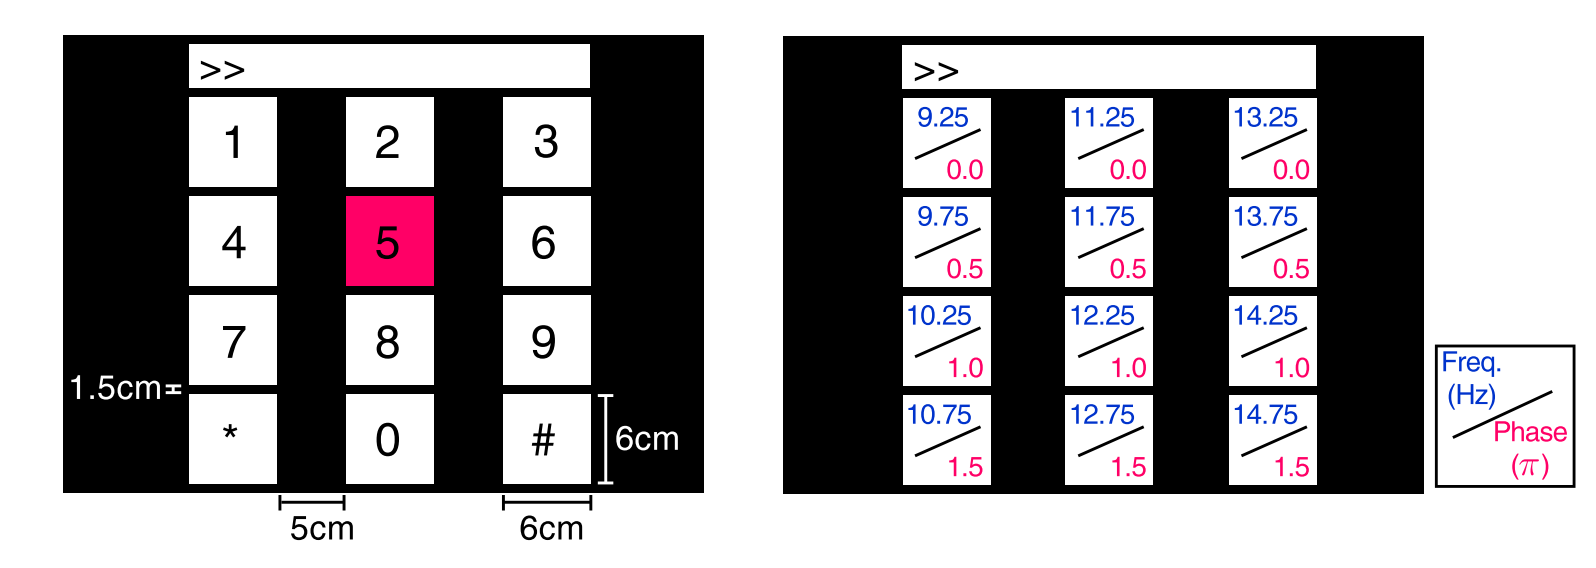
In this example, there are 12 SSVEP stimuli flashing at the corresponsing flicker frequencies. The user gazes at one of the flickering targets in random order for 4 seconds. In this way 15 trials are recorded from 8 EEG channels. For more details please refer to the paper.


#### Dataset URL:
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung,
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials,"
PLoS One, vol.10, no.10, e140703, 2015.

#### Implementation:
Note: Following implementation plots the frequency response of each flicker frequency across all trials on channel Oz. To visualize each flicker frequency's response, in this code, we average across all trials.

Borrowed from Aravind Ravi | eBionics Lab | University of Waterloo

In [21]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import pandas as pd

import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.metrics import confusion_matrix

# Helper Functions


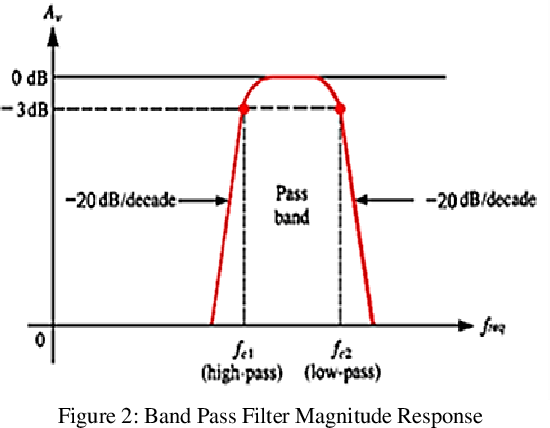

In [23]:
def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order):
    '''
    Returns bandpass filtered data between the frequency ranges specified in the input.

    Args:
        data (numpy.ndarray): array of samples.
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): order of the bandpass filter.

    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''

    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Filtering

The `get_filtered_eeg` function applies a bandpass filter to EEG data to extract specific frequency components of interest while removing unwanted noise. The `trial_len` variable in the code snippet represents the length of the segment of data that is being filtered by the bandpass filter.

Here's a breakdown of how `trial_len` is computed and its significance within this context:

1. **Input Data Dimensions:**
   The input `eeg` has the shape `(num_classes, num_channels, num_samples, num_trials)` where:
   - `num_classes`: Number of different classes or frequency bands you have.
   - `num_channels`: Number of EEG channels.
   - `num_samples`: Number of samples in the EEG data.
   - `num_trials`: Number of trials for each class.

2. **Purpose of the Loop:**
   The loop iterates over each target (class), each channel, and each trial to apply the bandpass filter to the corresponding EEG data.

3. **Computation of `trial_len`:**
   The variable `trial_len` is calculated using the equation:
   ```python
   trial_len = int(38 + 0.135 * sample_rate + 4 * sample_rate - 1) - int(38 + 0.135 * sample_rate)

This equation computes the length of the time segment that will be filtered. It represents the difference between two time points: one calculated using a starting point (38 ms after a certain event) and the other calculated using an ending point (38 ms after that event plus an additional 4 seconds, which is the duration of the segment to be filtered). The difference between these two time points gives you the length of the segment in terms of the number of samples.

In [24]:
def get_filtered_eeg(eeg, lowcut, highcut, order, sample_rate):
    '''
    Returns bandpass filtered eeg for all channels and trials.

    Args:
        eeg (numpy.ndarray): raw eeg data of shape (num_classes, num_channels, num_samples, num_trials).
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        order (int): order of the bandpass filter.
        sample_rate (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): bandpass filtered eeg of shape (num_classes, num_channels, num_samples, num_trials).
    '''

    num_classes = eeg.shape[0]
    num_chan = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]

    trial_len = int(38+0.135*sample_rate+4*sample_rate-1) - int(38+0.135*sample_rate)
    filtered_data = np.zeros((eeg.shape[0], eeg.shape[1], trial_len, eeg.shape[3]))

    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                signal_to_filter = np.squeeze(eeg[target, channel, int(38+0.135*sample_rate):
                                               int(38+0.135*sample_rate+4*sample_rate-1),
                                               trial])
                filtered_data[target, channel, :, trial] = butter_bandpass_filter(signal_to_filter, lowcut,
                                                                                  highcut, sample_rate, order)
    # Choose an example EEG data segment for visualization
    example_target = 0
    example_channel = 0
    example_trial = 0

    # Extract the EEG data segment
    original_signal = np.squeeze(eeg[example_target, example_channel,
                                    int(38 + 0.135 * sample_rate):
                                    int(38 + 0.135 * sample_rate + 4 * sample_rate - 1),
                                    example_trial])

    # Apply the bandpass filter
    filtered_signal = butter_bandpass_filter(original_signal, lowcut, highcut, sample_rate, order)

    # Plot the original and filtered signals
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(original_signal)
    plt.title('Original EEG Signal')
    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal)
    plt.title('Filtered EEG Signal')
    plt.tight_layout()
    plt.show()

    return filtered_data

In [25]:
def buffer(data, duration, data_overlap):
    '''
    Returns segmented data based on the provided input window duration and overlap.

    Args:
        data (numpy.ndarray): array of samples.
        duration (int): window length (number of samples).
        data_overlap (int): number of samples of overlap.

    Returns:
        (numpy.ndarray): segmented data of shape (number_of_segments, duration).
    '''

    number_segments = int(math.ceil((len(data) - data_overlap)/(duration - data_overlap)))
    temp_buf = [data[i:i+duration] for i in range(0, len(data), (duration - int(data_overlap)))]
    temp_buf[number_segments-1] = np.pad(temp_buf[number_segments-1],
                                         (0, duration-temp_buf[number_segments-1].shape[0]),
                                         'constant')
    segmented_data = np.vstack(temp_buf[0:number_segments])

    return segmented_data

In [26]:
def get_segmented_epochs(data, window_len, shift_len, sample_rate):
    '''
    Returns epoched eeg data based on the window duration and step size.

    Args:
        data (numpy.ndarray): array of samples.
        window_len (int): window length (seconds).
        shift_len (int): step size (seconds).
        sample_rate (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): epoched eeg data of shape.
        (num_classes, num_channels, num_trials, number_of_segments, duration).
    '''

    num_classes = data.shape[0]
    num_chan = data.shape[1]
    num_trials = data.shape[3]

    duration = int(window_len*sample_rate)
    data_overlap = (window_len - shift_len)*sample_rate

    number_of_segments = int(math.ceil((data.shape[2] - data_overlap)/
                                       (duration - data_overlap)))

    segmented_data = np.zeros((data.shape[0], data.shape[1],
                               data.shape[3], number_of_segments, duration))

    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                segmented_data[target, channel, trial, :, :] = buffer(data[target, channel, :, trial],
                                                                      duration, data_overlap)

    return segmented_data

# FFT
The `magnitude_spectrum_features` function calculates the magnitude spectrum features using the Fast Fourier Transform (FFT) on segmented EEG data. It extracts the frequency domain characteristics of the EEG signal within specified frequency bands.

Here's a breakdown of how the function works:

1. **Input Parameters:**
   - `segmented_data` (numpy.ndarray): Epoched EEG data of shape `(num_classes, num_channels, num_trials, number_of_segments, num_samples)`.
   - `FFT_PARAMS` (dict): Dictionary of parameters used for feature extraction. Includes:
     - `resolution` (float): Frequency resolution per bin (Hz).
     - `start_frequency` (float): Start frequency component to pick from (Hz).
     - `end_frequency` (float): End frequency component to pick up to (Hz).
     - `sampling_rate` (float): Sampling rate of the EEG data (Hz).

2. **Computing Variables:**
   The function calculates various dimensions and indices based on the input data and parameters:
   - `num_classes`, `num_channels`, `num_trials`, `number_of_segments`: Dimensions of the segmented EEG data.
   - `fft_len`: Length of the FFT.

3. **FFT Computation:**
   For each combination of target class, channel, trial, and segment:
   - A portion of the segmented EEG data is taken.
   - FFT is applied to this segment.
   - Magnitude spectrum is computed as `2 * absolute value of FFT`.
   - The magnitude spectrum within the specified frequency range is stored in the `features_data` array.

4. **Output Format:**
   The output `features_data` has a shape of `(n_fc, num_channels, num_classes, num_trials, number_of_segments)`, where `n_fc` is the number of frequency components in the specified frequency range.

In summary, the `magnitude_spectrum_features` function computes the magnitude spectrum of segmented EEG data within specified frequency bands. It returns a feature matrix capturing frequency domain characteristics for further analysis.


In [27]:
def magnitude_spectrum_features(segmented_data, FFT_PARAMS):
    '''
    Returns magnitude spectrum features. Fast Fourier Transform computed based on
    the FFT parameters provided as input.

    Args:
        segmented_data (numpy.ndarray): epoched eeg data of shape
        (num_classes, num_channels, num_trials, number_of_segments, num_samples).
        FFT_PARAMS (dict): dictionary of parameters used for feature extraction.
        FFT_PARAMS['resolution'] (float): frequency resolution per bin (Hz).
        FFT_PARAMS['start_frequency'] (float): start frequency component to pick from (Hz).
        FFT_PARAMS['end_frequency'] (float): end frequency component to pick upto (Hz).
        FFT_PARAMS['sampling_rate'] (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): magnitude spectrum features of the input EEG.
        (n_fc, num_channels, num_classes, num_trials, number_of_segments).
    '''

    num_classes = segmented_data.shape[0]
    num_chan = segmented_data.shape[1]
    num_trials = segmented_data.shape[2]
    number_of_segments = segmented_data.shape[3]
    fft_len = segmented_data[0, 0, 0, 0, :].shape[0]

    NFFT = round(FFT_PARAMS['sampling_rate']/FFT_PARAMS['resolution'])
    fft_index_start = int(round(FFT_PARAMS['start_frequency']/FFT_PARAMS['resolution']))
    fft_index_end = int(round(FFT_PARAMS['end_frequency']/FFT_PARAMS['resolution']))+1

    features_data = np.zeros(((fft_index_end - fft_index_start),
                              segmented_data.shape[1], segmented_data.shape[0],
                              segmented_data.shape[2], segmented_data.shape[3]))

    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                for segment in range(0, number_of_segments):
                    temp_FFT = np.fft.fft(segmented_data[target, channel, trial, segment, :], NFFT)/fft_len
                    magnitude_spectrum = 2*np.abs(temp_FFT)
                    features_data[:, channel, target, trial, segment] = magnitude_spectrum[fft_index_start:fft_index_end,]

    return features_data

# CCA

The following three functions work in conjunction to perform SSVEP (Steady-State Visually Evoked Potential) analysis using Canonical Correlation Analysis (CCA) and classify EEG signals based on reference templates:

1. **`get_cca_reference_signals(data_len, target_freq, sampling_rate)`**
   This function generates reference sinusoidal signals at different frequencies for CCA analysis. It takes parameters `data_len` (length of the signal), `target_freq` (target flicker frequency), and `sampling_rate` (sampling rate of the signal). It generates sine and cosine signals at the target frequency and its harmonics, combines them, and returns the reference signals as an array.

2. **`find_correlation(n_components, np_buffer, freq)`**
   This function calculates the correlation between EEG data and reference templates using CCA. It takes parameters `n_components` (number of CCA components), `np_buffer` (EEG data), and `freq` (reference templates). For each frequency in `freq`, it fits CCA models, computes canonical components, and calculates correlations. The maximum correlation is stored for each frequency.

3. **`cca_classify(segmented_data, reference_templates)`**
   This function classifies EEG segments using CCA and reference templates. It takes `segmented_data` (epoched EEG data) and `reference_templates` (generated reference signals). For each target class, trial, and segment, it computes correlations using `find_correlation` and predicts the class with the highest correlation. It returns the true labels and predicted class labels.

These functions work together to generate reference signals, calculate correlations using CCA, and classify EEG segments based on the most correlated reference signal. The result is a classification of EEG data according to the most prominent flicker frequency, which can be useful in SSVEP analysis.


# Canonical Correlation Analysis (CCA) in SSVEP Analysis

Canonical Correlation Analysis (CCA) is employed in the code to perform

1. **Generating Reference Signals:**
   The `get_cca_reference_signals` function generates reference sinusoidal signals at various frequencies. These signals serve as templates corresponding to the frequencies you wish to detect in the EEG data.

2. **Computing Correlations:**
   The `find_correlation` function is the core of CCA-related computations. For each frequency (class), it calculates the correlation between the EEG data and the respective reference template using Canonical Correlation Analysis.

   a. **Fitting the CCA Model:**
      For each frequency, the CCA model is fitted to both the EEG data and the reference template. This fitting process aims to identify linear transformations that maximize the correlation between the two datasets.

   b. **Data Transformation:**
      Once the CCA model is trained, it transforms both the EEG data and reference template into a new space where correlations between the transformed variables are maximized.

   c. **Correlation Calculation:**
      The correlations between the transformed variables are computed using `np.corrcoef`. These correlation values quantify how well the EEG data segment correlates with the reference template.

   d. **Maximizing Correlation:**
      The maximum correlation for each frequency is identified. This value indicates the strength of the relationship between the EEG data segment and the corresponding reference template.

3. **Classification Based on Correlations:**
   The `cca_classify` function utilizes the maximum correlation values obtained from `find_correlation` to classify EEG segments into different classes (frequencies). For each EEG segment, it selects the frequency (class) associated with the highest correlation.

   a. **Data Iteration:**
      The function iterates through the segmented EEG data, considering each target class, trial, and segment.

   b. **Correlation Calculation:**
      For every EEG segment, the maximum correlation is computed using `find_correlation`. The class (frequency) with the highest correlation is chosen.

   c. **Predicted Class Assignment:**
      The EEG segment is assigned the predicted class (frequency) corresponding to the highest correlation.

CCA is used to determine the correlations between EEG segments and reference sinusoidal signals at different frequencies. These correlations gauge the degree of resemblance between EEG data and reference templates. The highest correlation value is employed to classify EEG segments into distinct classes (frequencies), enabling the execution of SSVEP analysis and EEG signal classification based on their correlation with reference signals.

In [28]:
def get_cca_reference_signals(data_len, target_freq, sampling_rate):
    reference_signals = []
    t = np.arange(0, (data_len/(sampling_rate)), step=1.0/(sampling_rate))
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)

    return reference_signals

def find_correlation(n_components, np_buffer, freq):
    cca = CCA(n_components)
    corr = np.zeros(n_components)
    result = np.zeros(freq.shape[0])
    for freq_idx in range(0,freq.shape[0]):
        cca.fit(np_buffer.T,np.squeeze(freq[freq_idx, :, :]).T)
        O1_a,O1_b = cca.transform(np_buffer.T, np.squeeze(freq[freq_idx, :, :]).T)
        ind_val = 0
        for ind_val in range(0,n_components):
            corr[ind_val] = np.corrcoef(O1_a[: ,ind_val], O1_b[:, ind_val])[0 ,1]
            result[freq_idx] = np.max(corr)

    return result

def cca_classify(segmented_data, reference_templates):
    predicted_class = []
    labels = []
    for target in range(0, segmented_data.shape[0]):
        for trial in range(0, segmented_data.shape[2]):
            for segment in range(0, segmented_data.shape[3]):
                labels.append(target)
                result = find_correlation(1, segmented_data[target, :, trial, segment, :],
                                      reference_templates)
                predicted_class.append(np.argmax(result)+1)
    labels = np.array(labels)+1
    predicted_class = np.array(predicted_class)

    return labels, predicted_class

In [29]:
def plot_spectrum(ax, magnitude_spectrum, resolution, num_classes, subject, channel, flicker_freq):
    for target in range(num_classes):
        fft_axis = np.arange(magnitude_spectrum.shape[0])*resolution
        ax[target].plot(fft_axis, np.mean(np.squeeze(magnitude_spectrum[:, channel, target, :, :]),
                                          axis=1))
        ax[target].set_xlabel('Frequency (Hz)')
        ax[target].set_ylabel('Amplitude (uV)')
        ax[target].set_title(f'Subject {subject} stimulus frequency {flicker_freq[target]} Hz')
    plt.show()

# Load the dataset




In [30]:
FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 0.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}
data_path = os.path.abspath('data')
all_segment_data = dict()
magnitude_spectrum = dict()
all_acc = list()
window_len = 4
shift_len = 4
sample_rate = FFT_PARAMS['sampling_rate']
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75,
                       10.25, 12.25, 14.25, 10.75, 12.75, 14.75])
duration = int(window_len*sample_rate)

# Frequency Response calculated using Fast-Fourier Transform (FFT)

# CCA
#### Generating the required sinusoidal templates for the given 12-class SSVEP classification

# Perform CCA on the segmented epochs